In [1]:
from loica import *
import matplotlib.pyplot as plt
import numpy as np
import getpass

In [2]:
from flapjack import *
#fj = Flapjack(url_base='flapjack.rudge-lab.org:8000')
fj = Flapjack(url_base='localhost:8000')
fj.log_in(username=input('Flapjack username: '), password=getpass.getpass('Password: '))

Flapjack username: tim
Password: ········


In [3]:
study = fj.create('study', name='Loica testing', description='Test study for demonstrating Loica')

One or more study already exists, type "yes" to replace them:


In [20]:
dna = fj.create('dna', name='receiver1')
vector = fj.create('vector', name='receiver1', dnas=dna.id)

One or more dna already exists, type "yes" to replace them:
One or more vector already exists, type "yes" to replace them:


In [21]:
network = GeneticNetwork(vector=vector.id[0])

In [22]:
sfp = fj.create('signal', name='SFP', color='green', description='Simulated fluorescent protein')
reporter = Reporter(name='SFP', color='green', degradation_rate=0, init_concentration=0, signal_id=sfp.id[0])

One or more signal already exists, type "yes" to replace them:


In [23]:
network.add_reporter(reporter)

In [24]:
ahl = Supplement(name='AHL1')
rec = Receiver(input=ahl, output=reporter, a=0, b=1000, K=1, n=2)
network.add_operator(rec)

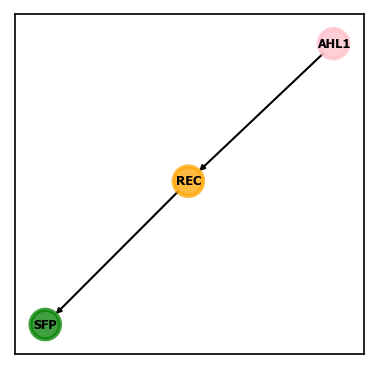

In [25]:
plt.figure(figsize=(3,3), dpi=150)
network.draw()

In [26]:
def growth_rate(t):
    return gompertz_growth_rate(t, 0.05, 1, 1, 1)

def biomass(t):
    return gompertz(t, 0.05, 1, 1, 1)
    
metab = SimulatedMetabolism(biomass, growth_rate)

media = fj.create('media', name='loica', description='Simulated loica media')
strain = fj.create('strain', name='loica', description='Loica test strain')

One or more media already exists, type "yes" to replace them:
One or more strain already exists, type "yes" to replace them:


In [27]:
# Create list of samples    
samples = []
concs = np.append(0, np.logspace(-6, 6, 24))
for conc in concs:
    sample = Sample(genetic_network=network, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0])
    # Add AHL to samples at given concentration
    sample.add_supplement(ahl, conc)
    samples.append(sample)

In [28]:
biomass_signal = fj.create('signal', name='SOD', description='Simulated OD', color='black')
assay = Assay(samples, 
              n_measurements=100, 
              interval=0.24,
              name='Loica receiver1',
              description='Simulated receiver generated by loica',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run(nsr=0)

One or more signal already exists, type "yes" to replace them:


In [29]:
assay.upload(fj, study.id[0])

One or more assay already exists, type "yes" to replace them:yes


In [30]:
rec.characterize(
    fj,
    vector=vector.id,
    media=media.id,
    strain=strain.id,
    signal=sfp.id,
    biomass_signal=biomass_signal.id
)

100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 136.20it/s]


Returning dataframe


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 151.17it/s]


Returning dataframe


In [31]:
rec.a, rec.b, rec.K, rec.n

(0.00018698345313776626,
 1007.9741027129568,
 1.000000291238369,
 2.000000778448353)